# BA885 Team Project
#### Christian Lawrence, Tianzheng Mao, Tiam Moradi, Phoenix Wang

To access the dataset, please add the following shared folders to your working directory:
* https://tinyurl.com/3cn2zk8u (labeled images)
* https://tinyurl.com/ypaf8wtt (unlabeled images)

# Environment Setup

In [1]:
# # mount Google Drive
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
# # set working directory
# import os
# # os.chdir("/content/gdrive/MyDrive/BA885 Team Project") # Phoenix's
# os.chdir("/content/gdrive/MyDrive/MSBA/BA885/BA885 Team Project") # Christian's

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
# %tensorflow_version 2.x
import PIL
import PIL.Image
import pathlib
import matplotlib.image as mpimg
from matplotlib import rcParams

# Data Setup

In [38]:
# Utility function 
def prepare_image(img_path, img_size = 150):
   img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
   img_array = tf.keras.preprocessing.image.img_to_array(img)
   img_array_expanded_dims = np.expand_dims(img_array, axis=0)
   return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [2]:
# load all the labeled images
# data_dir = pathlib.Path('/content/gdrive/MyDrive/BA885 Team Project/Labeled') # Phoenix's
# data_dir = pathlib.Path('D:/GitHub/BA885-Image-Classification/Labeled') # Phoenix's
data_dir = pathlib.Path('./Labeled') # Christian's
print('Total number of labeled images:', len(list(data_dir.glob('*/*.jpg'))))

Total number of labeled images: 17034


In [3]:
# put labeled images under their corresponding directory
labels = ['building', 'forest', 'glacier', 'mountain', 'sea', 'street']
for i in labels:
    count = len(list(data_dir.glob(i+'/*')))
    locals()[i] = list(data_dir.glob(i+'/*'))
    print(f'There are {count} images in "{i}" directory.')

There are 2628 images in "building" directory.
There are 2745 images in "forest" directory.
There are 2957 images in "glacier" directory.
There are 3037 images in "mountain" directory.
There are 2784 images in "sea" directory.
There are 2883 images in "street" directory.


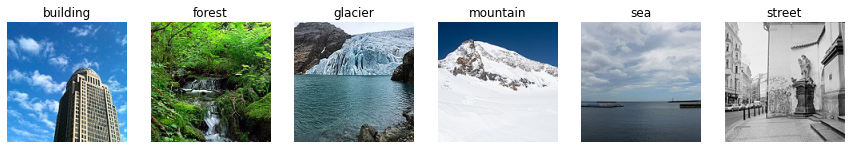

In [9]:
# display an image from each directory
rcParams['figure.figsize'] = 15, 5
fig, ax = plt.subplots(1, 6)

dirs = [building, forest, glacier, mountain, sea, street]
for i, v in enumerate(dirs):
    ax[i].imshow(PIL.Image.open(str(v[0])))
    ax[i].axis('off')
    ax[i].title.set_text(labels[i]);

In [10]:
# shape of each image
tf.keras.preprocessing.image.img_to_array(PIL.Image.open(str(building[0]))).shape

(150, 150, 3)

## Preprocessing

Use 80% of the images for training and 20% for validation.

In [5]:
batch_size = 32
img_height = 150
img_width = 150

In [6]:
# generate training set
train_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 13628 files for training.


In [7]:
# generate validation set
val_ds_labeled = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=885,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 17034 files belonging to 6 classes.
Using 3406 files for validation.


Each batch contains 32 images of shape `(150, 150, 3)` and their corresponding labels.

In [9]:
# shape of each batch
image_batch, label_batch = next(iter(train_ds_labeled))
print(image_batch.shape)
print(label_batch.shape)

(32, 150, 150, 3)
(32,)


## Rescaling

The RGB channel values are in the `[0, 255]` range. We'll rescale the values to be in the `[0, 1]` range.

In [10]:
# value range from 0 to 255
image_batch, label_batch = next(iter(train_ds_labeled))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 255.0


In [11]:
standardization = tf.keras.layers.experimental.preprocessing.Rescaling(1/255)
train_ds = train_ds_labeled.map(lambda x, y: (standardization(x), y))
val_ds = val_ds_labeled.map(lambda x, y: (standardization(x), y))

In [13]:
# value range from 0 to 1
image_batch, label_batch = next(iter(train_ds))
print('Minimum value:', np.min(image_batch))
print('Maximum value:', np.max(image_batch))

Minimum value: 0.0
Maximum value: 1.0


In [14]:
# configure performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building and Training

## Model 1 - Fully-Connected Neural Network
* No convolutional layer
* Use 1 hidden dense layer

In [21]:
# building model
num_classes = 6
model1 = tf.keras.Sequential([# tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              # tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Flatten(input_shape=(150, 150, 3)),
                            #   tf.keras.layers.GlobalAveragePooling2D(),
                              # fully-connected layers
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(num_classes)
                            ])

model1.compile(optimizer='adam',
               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [27]:
# training model
epochs = 10
model1_history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
427/427 [==============================] - 42s 97ms/step - loss: 1.6741 - accuracy: 0.2702 - val_loss: 1.6855 - val_accuracy: 0.2945
Epoch 2/10
427/427 [==============================] - 36s 84ms/step - loss: 1.6073 - accuracy: 0.2942 - val_loss: 1.5976 - val_accuracy: 0.2971
Epoch 3/10
427/427 [==============================] - 34s 80ms/step - loss: 1.5687 - accuracy: 0.3047 - val_loss: 1.5739 - val_accuracy: 0.3024
Epoch 4/10
427/427 [==============================] - 36s 84ms/step - loss: 1.5509 - accuracy: 0.3137 - val_loss: 1.5651 - val_accuracy: 0.3062
Epoch 5/10
427/427 [==============================] - 33s 77ms/step - loss: 1.5323 - accuracy: 0.3226 - val_loss: 1.5595 - val_accuracy: 0.3103
Epoch 6/10
427/427 [==============================] - 23s 53ms/step - loss: 1.5189 - accuracy: 0.3294 - val_loss: 1.5770 - val_accuracy: 0.3027
Epoch 7/10
427/427 [==============================] - 33s 76ms/step - loss: 1.5081 - accuracy: 0.3329 - val_loss: 1.5914 - val_accuracy:

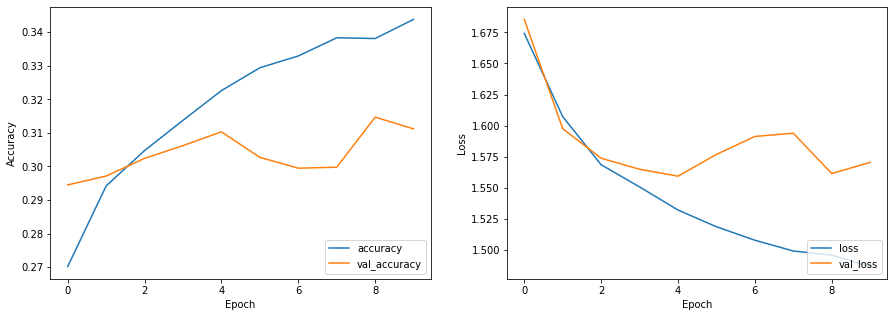

In [163]:
plt.subplot(1,2,1)
plt.plot(model1_history.history['accuracy'], label='accuracy')
plt.plot(model1_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

plt.subplot(1,2,2)
plt.plot(model1_history.history['loss'], label='loss')
plt.plot(model1_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right');

It seems that the fully-connected neural network failed to converge with 10 epochs. The validation accuracy seems to be relatively flat throughout each epoch progression and the training accuracy seems to be increasing linearly. Overfitting seems to be present as evidenced by the diverging accuracy lines.

With a validation accuracy of ~30-33%, our model classifies only twice as well as a roll of a 6-sided dice.

In [28]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               8640128   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 8,640,902
Trainable params: 8,640,902
Non-trainable params: 0
_________________________________________________________________


In [244]:
# model1.save('./models/model_FCNN')
# model1.save('D:/GitHub/BA885-Image-Classification/Models/model_FCNN')

2
True label is: glacier
Predicted label is: mountain


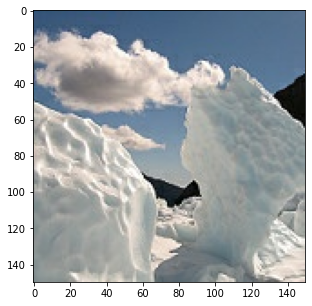

In [241]:
one_batch = next(iter(val_ds_labeled.take(2)))
# the true label
tlabel = one_batch[1][0].numpy()
print(tlabel)
print("True label is: {}".format(val_ds_labeled.class_names[tlabel]))
# the image
plt.imshow(one_batch[0][0].numpy().astype("uint8"))
# run prediction
predictions = model1.predict(one_batch[0])
print("Predicted label is: {}".format(val_ds_labeled.class_names[np.argmax(predictions[0])]))

Predictions:


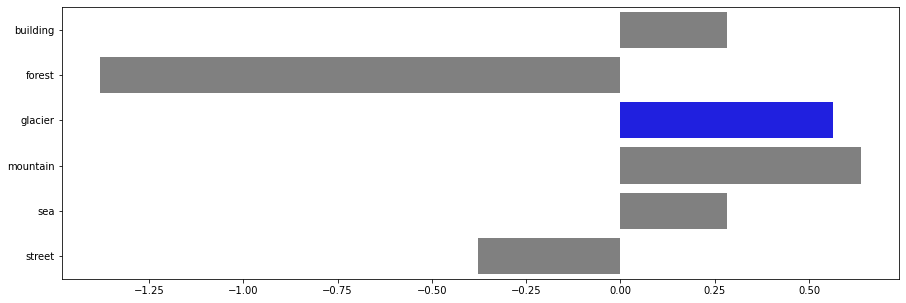

In [242]:
print("Predictions:")
clrs = ['blue' if (val_ds_labeled.class_names[x] == val_ds_labeled.class_names[tlabel]) else 'grey' for x in range(len(predictions[0]))]
sns.barplot(x = predictions[0], y = val_ds_labeled.class_names, palette=clrs);

This model clearly misclassifies our image and seems unconfident with its prediction.

## Model 2
* Use 3 convolutional layers
* Use 1 hidden dense layer

In [30]:
# building model
num_classes = 6
model2 = tf.keras.Sequential([tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Conv2D(32, 3, activation='relu'),
                              tf.keras.layers.MaxPooling2D(),
                              tf.keras.layers.Flatten(),
                             #  tf.keras.layers.GlobalAveragePooling2D(),
                              # fully-connected layers
                              tf.keras.layers.Dense(128, activation='relu'),
                              tf.keras.layers.Dense(num_classes)
                            ])

model2.compile(optimizer='adam',
               loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [31]:
# training model
epochs = 10
model2_history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
427/427 [==============================] - 280s 648ms/step - loss: 0.9629 - accuracy: 0.6287 - val_loss: 0.7749 - val_accuracy: 0.7111
Epoch 2/10
427/427 [==============================] - 234s 546ms/step - loss: 0.6784 - accuracy: 0.7496 - val_loss: 0.6469 - val_accuracy: 0.7679
Epoch 3/10
427/427 [==============================] - 245s 572ms/step - loss: 0.5206 - accuracy: 0.8096 - val_loss: 0.6432 - val_accuracy: 0.7728
Epoch 4/10
427/427 [==============================] - 241s 563ms/step - loss: 0.4057 - accuracy: 0.8527 - val_loss: 0.5955 - val_accuracy: 0.7974
Epoch 5/10
427/427 [==============================] - 213s 497ms/step - loss: 0.3170 - accuracy: 0.8875 - val_loss: 0.6688 - val_accuracy: 0.7740
Epoch 6/10
427/427 [==============================] - 209s 488ms/step - loss: 0.2482 - accuracy: 0.9119 - val_loss: 0.6501 - val_accuracy: 0.7945
Epoch 7/10
427/427 [==============================] - 210s 490ms/step - loss: 0.1996 - accuracy: 0.9300 - val_loss: 0.7542 -

In [178]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9248)             

In [243]:
# model2.save('./models/model_CNN')
# model2.save('D:/GitHub/BA885-Image-Classification/Models/model_CNN')

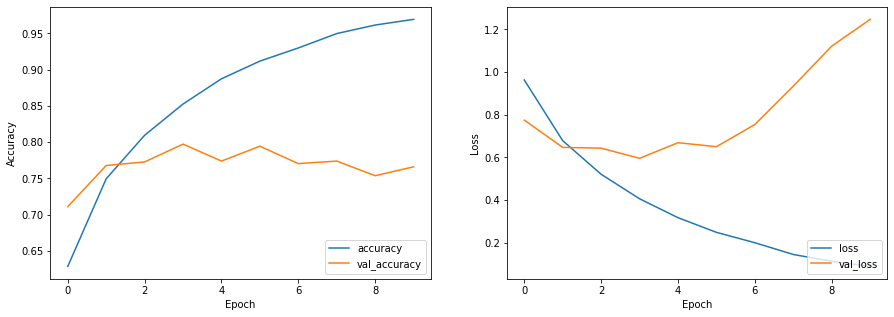

In [162]:
plt.subplot(1,2,1)
plt.plot(model2_history.history['accuracy'], label='accuracy')
plt.plot(model2_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

plt.subplot(1,2,2)
plt.plot(model2_history.history['loss'], label='loss')
plt.plot(model2_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right');

It looks like this model performs better than our first FCNN model based on its higher accuracy scores. However, overfitting is still present as shown by the diverging accuracy curves. While the training set seems to be approaching convergence. It doesn't seem like the validation set converged. 

5
True label is: street
Predicted label is: street


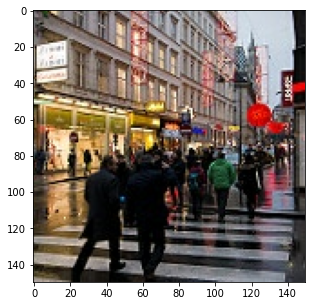

In [231]:
one_batch = next(iter(val_ds_labeled.take(2)))
# the true label
tlabel = one_batch[1][0].numpy()
print(tlabel)
print("True label is: {}".format(val_ds_labeled.class_names[tlabel]))
# the image
plt.imshow(one_batch[0][0].numpy().astype("uint8"))
# run prediction
predictions = model2.predict(one_batch[0])
print("Predicted label is: {}".format(val_ds_labeled.class_names[np.argmax(predictions[0])]))

Predictions:


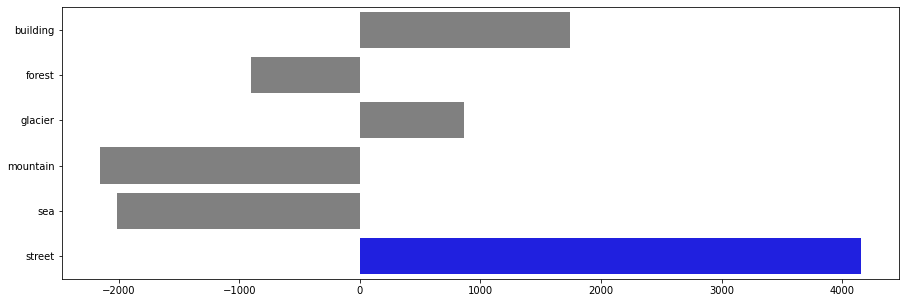

In [233]:
print("Predictions:")
clrs = ['blue' if (val_ds_labeled.class_names[x] == val_ds_labeled.class_names[tlabel]) else 'grey' for x in range(len(predictions[0]))]
sns.barplot(x = predictions[0], y = val_ds_labeled.class_names, palette=clrs);

5
True label is: street
Predicted label is: glacier


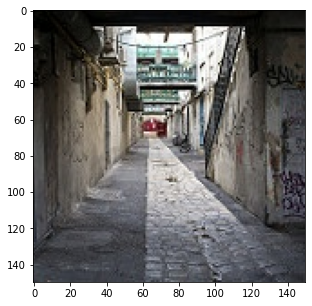

In [235]:
# run prediction
one_batch = next(iter(val_ds_labeled.take(1)))
# the true label
tlabel = one_batch[1][0].numpy()
print(tlabel)
print("True label is: {}".format(val_ds_labeled.class_names[tlabel]))
# the image
plt.imshow(one_batch[0][0].numpy().astype("uint8"))
# run prediction
predictions = model2.predict(one_batch[0])
print("Predicted label is: {}".format(val_ds_labeled.class_names[np.argmax(predictions[0])]))

Predictions:


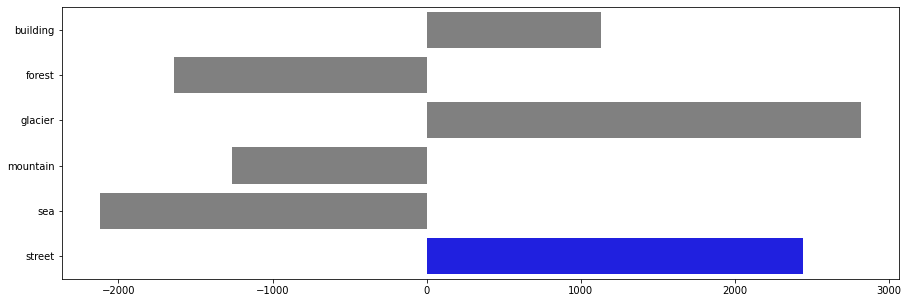

In [236]:
print("Predictions:")
clrs = ['blue' if (val_ds_labeled.class_names[x] == val_ds_labeled.class_names[tlabel]) else 'grey' for x in range(len(predictions[0]))]
sns.barplot(x = predictions[0], y = val_ds_labeled.class_names, palette=clrs);

It looks like our model performs better, but still has a lot of room for improvement. We suspect that it has a difficult time differentiating 'nature' images (mountain vs glacier) from one another, but is able to classify urban vs nature images well.

### Inspect convoluted layer

#### First C-Layer

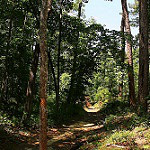

In [208]:
PIL.Image.open('./Labeled/forest/20089.jpg')

In [209]:
inspectLayerModel = tf.keras.models.Model(inputs=model2.input, outputs=model2.get_layer('conv2d_3').output)
# image we are going to use 
myimg = prepare_image(img_path='./Labeled/forest/20089.jpg')
features0= inspectLayerModel.predict(myimg)

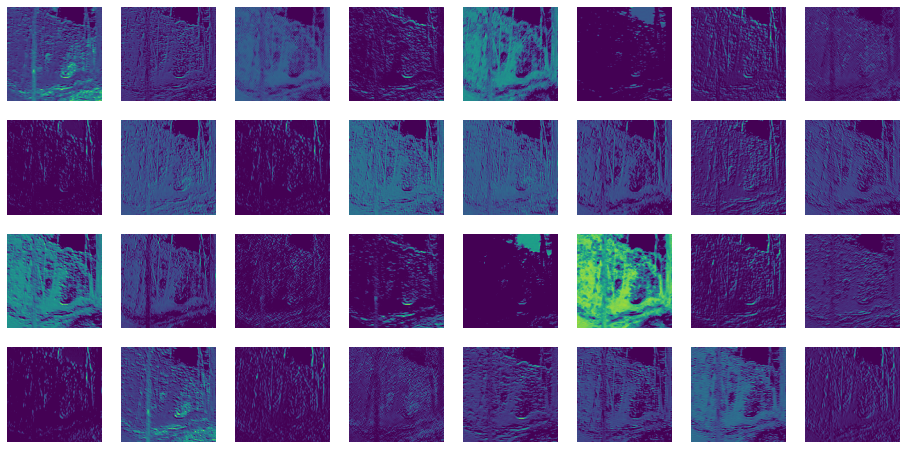

In [210]:
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i])
    # ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(images[i].astype("uint8"))
    # plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

It seems that the first layer tries to capture the different lines and distinct shapes of the image. For example, for our image, it picks up the shape of the trees and the empty space around it.

#### Last C-Layer

In [200]:
# inspect convoluted layer
inspectLayerModel = tf.keras.models.Model(inputs=model2.input, outputs=model2.get_layer('conv2d_5').output)
# image we are going to use 
myimg = prepare_image(img_path='./Labeled/forest/20089.jpg')
features0= inspectLayerModel.predict(myimg)

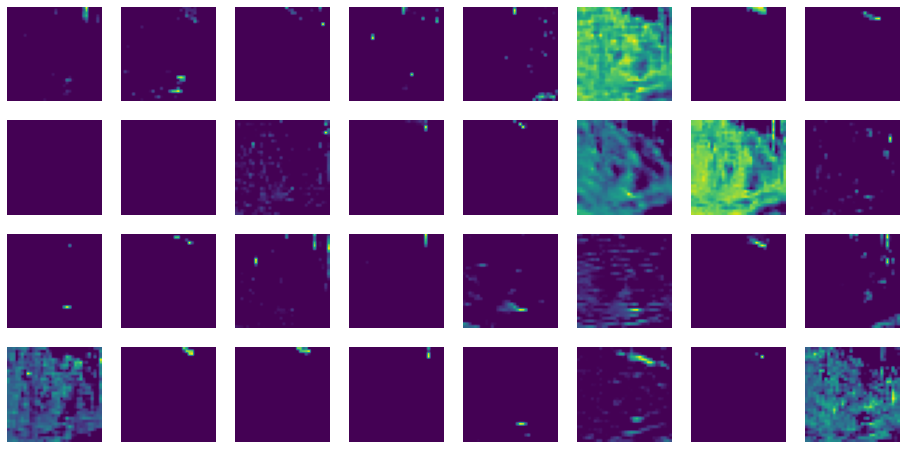

In [201]:
plt.figure(figsize=(16, 8))
N=32
for images in features0:
  for i in range(N):
    plt.subplot(4,8,i+1)
    plt.imshow(features0[0,:,:,i])
    # ax = plt.subplot(3, 3, i + 1)
    # plt.imshow(images[i].astype("uint8"))
    # plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

The last convoluted layer seems to show the signals (or lack thereof) more distinctly. For example, filter (6,1) and filter (7,2) seems to identify the trees as signals quite well. Other filters seem to try capturing the various sections of the empty patch of sky (blue) in the upper right corner of the image.